In [182]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import os
import math

from scipy.stats import ttest_ind
from scipy.stats import ttest_rel
import scipy.stats as stats

#from mpltools import special ##leon

plt.style.use('seaborn-poster')

# DEFINE DATA CLASS
class RawData(object):
    def __init__(self,timestamp,keytime,ttime,keypress,targetid,target_lon,target_lat,target_x,target_y,target_z,hmd_rx,hmd_ry,hmd_rz):
        self.timestamp=timestamp # 1 (default time?)
        self.keytime=keytime # 2 +Time.deltaTime
        self.ttime=ttime # 3 Time.time
        self.keypress=keypress # 4
        self.targetid=targetid # 5
        self.target_lon=target_lon
        self.target_lat=target_lat
        self.target_x=target_x
        self.target_y=target_y
        self.target_z=target_z
        self.hmd_rx=hmd_rx # 11
        self.hmd_ry=hmd_ry # 12
        self.hmd_rz=hmd_rz # 13

class TimeData(object):
    def __init__(self,targetid,target_lon,target_lat,deltatime):
        self.targetid=targetid
        self.target_lon=target_lon
        self.target_lat=target_lat
        self.deltatime=deltatime


class User(object):
    def __init__(self, lat, lon, user, test):
        self.lat=lat
        self.lon=lon
        self.user=user
        self.test=test
        self.speed_array = [[] for x in range(5)]
        self.time_array = [[] for x in range(5)]
        self.speed_raw = [[] for x in range(5)]
        self.time_raw = [[] for x in range(5)]
        self.speed_mean = [[] for x in range(5)]
        self.speed_std = [[] for x in range(5)]
        self.time_mean = [[] for x in range(5)]
        self.time_std = [[] for x in range(5)]
        #print(np.array(self.speed_array).shape)


        
    ## READ DATA
    def _read_data(self, file):
        raw_data=[]
        print("Reading %s"%file)
        seperator="\t"
        with open(file,"r") as fp:
            for line in fp:
                if line.startswith("Time"):
                    continue     ## Skip the Header
                l=line[:-1]   ## Delete the Last Element then Return
                f=l.split(seperator)   ## Divide the Raw Data to Pieces
                if(int(f[3])==1):   ## 4.When Finish Targeting and Press Key
                    raw_data.append(RawData(f[0],float(f[1]),float(f[2]),float(f[3]),float(f[4]),float(f[5]),float(f[6]),float(f[7]),float(f[8]),float(f[9]),float(f[10]),float(f[11]),float(f[12])))
                else: 
                    raw_data.append(RawData(f[0],float(f[1]),float(f[2]),float(f[3]),float(f[4]),0,0,0,0,0,float(f[10]),float(f[11]),float(f[12])))

        return raw_data



    # Input Raw Data, Each Tester, return aim_time[[[,,,],,,,,][,,,,,][,,,,,]] 3-layer array
    # Every Target Aiming Time in aim_time[lat][lon] = [first, second, third]
    def _aim_time_filter(self, input_raw_data):
        aim_time={}
        filtered_data=[a for a in input_raw_data if a.keypress==1]

        for i in range(len(filtered_data)-1):
            if(filtered_data[i+1].targetid!=filtered_data[i].targetid):
                continue # when resuming back
            if((i <= len(filtered_data)-3) and (filtered_data[i-1].targetid==filtered_data[i+2].targetid)):
                continue # when two same targets appear one after one
            delta_time=filtered_data[i+1].ttime-filtered_data[i].ttime
            #print(delta_time, filtered_data[i].targetid)

            key1=str(int(filtered_data[i].target_lat))
            key2=str(int(filtered_data[i].target_lon))
            if(key1 in aim_time)==False:
                aim_time[key1]={}
            if(key2 in aim_time[key1])==False:
                aim_time[key1][key2]=[]

            aim_time[key1][key2].append(TimeData(filtered_data[i].targetid,filtered_data[i].target_lon,filtered_data[i].target_lat,delta_time))

        aim_time[str(0)][str(0)]=[]   # Special (0,0) Not Exist but for data processing, add a pseudo datum
        aim_time[str(0)][str(0)].append(TimeData(float(21),float(0),float(0),float(0)))

        return aim_time   # aim_time is 3*3*7 array{}

    LAT_KEY = ('-30','0','30')
    LON_KEY = ['0','30','60','90','120','150','180']

    def _extract_time(self, input_time):
        #lat = [a for a in input_time]
        #lon = [b for b in input_time[lat]]
        #target = [c.deltatime for c in input_time[lon] ]
        
        time_dict = {}
        #time_flat = [] # not useful, not sorted
        
        lat_order = ['-30','0','30']
        lon_order = ['0','30','60','90','120','150','180']
        
        for lat in lat_order:
            time_dict[lat] ={}
            #time_lon = []
            for lon in lon_order:
                time_dict[lat][lon] = [target.deltatime for target in input_time[lat][lon]]
                #time_target = [target.deltatime for target in input_time[lat][lon]]
                #time_lon.append(time_target)
            #time_flat.append(time_lon)

        return time_dict#, time_flat

    def _flatten_data(self, input_data):
        
        flat_data = []
        
        for lat in input_data:
            data_lon = []
            for lon in input_data[lat]:
                data_target = [target for target in input_data[lat][lon]]
                data_lon.append(data_target)
            flat_data.append(data_lon)
        
        return flat_data
    
    def _time_to_speed(self, input_time):
        
        speed={}
        
        for lat in input_time:
            speed[lat]={}
            for lon in input_time[lat]:
                speed[lat][lon]=[]
                for target in range(len(input_time[lat][lon])):
                    if (input_time[lat][lon][target]==0):
                        #r.append(0) # speed = 0
                        speed[lat][lon].append(0)
                        continue
                    
                    angle = User._angle_ac(self, int(lat), int(lon))
                    speed[lat][lon].append( angle / input_time[lat][lon][target] )

        return speed    # 3*3*7 array{}

    def _angle_ap(self, lat, lon):
        angle = math.sqrt( lat**2 + lon**2 )
        return angle

    def _angle_ac(self, lat, lon):
        angle = math.degrees( math.acos( math.cos(math.radians(lat)) * math.cos(math.radians(lon)) ) )
        return angle

    # Calculate the Mean and STD
    def _dict_stat(input_dict): # return

        key1=['-30','0','30']    # 3 lat
        if (len(input_dict) == 1):
            key1=['0']    # 1 lat
        key2=[0,30,60,90,120,150,180]
        
        #key3= [lat for lat in input_dict]
        #key4= [lon for lon in input_dict[key3[0]]]
        key3 = input_dict.keys()
        key4 = input_dict['0'].keys()
    
        if (tuple(input_dict.keys()) != User.LAT_KEY):
            print('Error may happen')
        
        target_mean={}
        target_std={}
        for lat in input_dict:
            target_mean[lat]={}
            target_std[lat]={}
            for lon in input_dict[lat]:
                if(input_dict[lat][lon]==[0]):
                #if(k2==0):
                    target_mean[lat][lon]=0
                    target_std[lat][lon]=0
                    continue
                
                target_mean[lat][lon]=np.mean(input_dict[lat][lon])
                target_std[lat][lon]=np.std(input_dict[lat][lon])

        return target_mean, target_std    # 3*7 array[]

    def _list_stat(input_data): # return
        
        print(np.array(input_data).shape)
            
        target_mean=[]
        target_std=[]
        
        #for lon in range(len(input_data)):
        for lat in range(3):
            mean=[]
            std=[]
            #for lat in range(len(input_data[lon])):
            for lon in range(7):
                #if(lon==1 and lat==0):
                #if(k2==0):
                if (input_data[lat][lon] == [0]):
                    mean.append(0)
                    std.append(0)
                    continue
                data = [target for target in input_data[lat][lon]]
                
                mean.append(np.mean(data))
                std.append(np.std(data))
    
            target_mean.append(mean)
            target_std.append(std)

        return target_mean, target_std    # 3*7 array[]


    def add_test(self, test, file):
        raw_data = User._read_data(self, file)
        aim_time = User._aim_time_filter(self, raw_data)
        time_dict = User._extract_time(self, aim_time)
        time_flat = User._flatten_data(self, time_dict)
        speed_dict = User._time_to_speed(self, time_dict)
        speed_flat = User._flatten_data(self, speed_dict)
        
        #self.speed_array.append(np.array(speed_flat))
        self.time_array[test-1] = np.array(time_flat)
        self.speed_array[test-1] = np.array(speed_flat)
        #self.time_raw.append(time_dict)
        self.time_raw[test-1] = time_dict
        self.speed_raw[test-1] = speed_dict
        
        self.time_mean[test-1], self.time_std[test-1] = User._list_stat(time_flat)
        self.speed_mean[test-1], self.speed_std[test-1] = User._list_stat(speed_flat)
        
        #self.time_mean = User._dict_stat
    
    def dict_print(dict_to_print):
        for x in dict_to_print:
            print ('--', x, '--')
            for y in dict_to_print[x]:
                print (y,':', dict_to_print[x][y])
                
    #def _mean(self, array):
    
    def _cal_ratio(before, after):
        
        ratio=[]
        log=[]
        
        for i in range(len(before)):
            r=[]
            l=[]
            #print(len(before[i]))
            for j in range(len(before[i])):
                if(after[i][j]==0):
                    r.append(1) #ratio
                    l.append(0) #log
                    continue
                r.append( after[i][j] / before[i][j] ) #ratio
                l.append( math.log2( after[i][j] / before[i][j] ) ) #log
                #print(i,j,mean_after[i][j],mean_before[i][j])
            ratio.append(r)
            log.append(l)
            
        print(np.array(ratio).shape)
        print(np.array(log).shape)
        return ratio,log
    
    def ratio_of(self, data_type, before, after):
        if (data_type == 'time'):
            data_before = self.time_mean[before-1]
            data_after = self.time_mean[after-1]
        if (data_type == 'speed'):
            data_before = self.speed_mean[before-1]
            data_after = self.speed_mean[after-1]
        
        print(np.array(self.speed_mean).shape)
        
        print(np.array(self.speed_mean[before-1]).shape, np.array(data_before).shape)
        ratio, log = User._cal_ratio(data_before, data_after)
        return ratio, log
            
        
        
        
        
       


#User    






Reading ../Users/1/1.txt
(3, 7)
(3, 7)
Reading ../Users/1/2.txt
(3, 7)
(3, 7)
(5,)
(3, 7) (3, 7)
(3, 7)
(3, 7)
(3, 7)
!


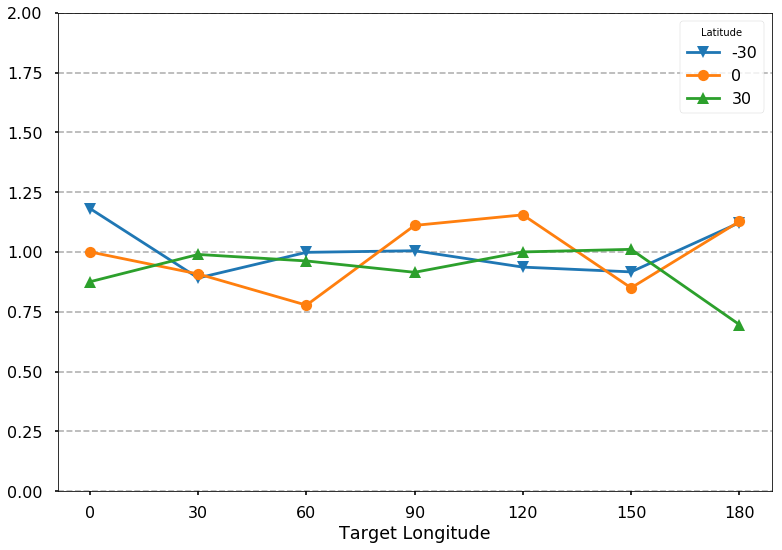

Reading ../Users/2/1.txt
(3, 7)
(3, 7)
Reading ../Users/2/2.txt
(3, 7)
(3, 7)
(5,)
(3, 7) (3, 7)
(3, 7)
(3, 7)
(3, 7)
!


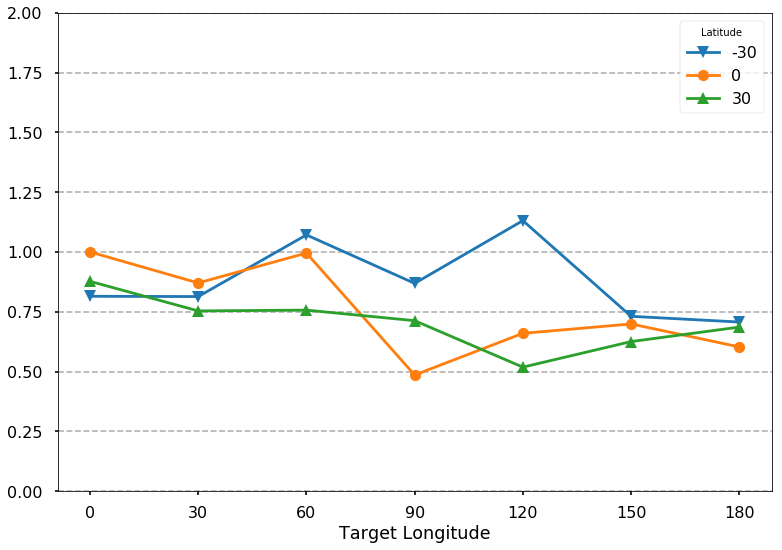

[list([1, 2]) list([1, 2, 3])]


In [198]:

###################### choose user
#users=[1,2,3,4,5,9,10,14,6,12,13,8,11,7]#after 13
#users=[14,16,17,18,19,15]
users=[1,2]
######################


user_all = [] 
for uid in range(len(users)):
    baseFolder=str(users[uid])
    #idx=[3,4,5]
    test_id=[1,2]

    #baseFolder = "1"
    #raw_data = read_data("../Users/"+baseFolder+"/"+str(idx[0])+".txt")

    user_temp = User(1,1,uid,1)
    #print(user1.time_raw[0])
    for idx in range(len(test_id)):
        user_temp.add_test(test_id[idx],"../Users/"+baseFolder+"/"+str(test_id[idx])+".txt")
    user_all.append(user_temp)

#User.dict_print(user_all[0].time_raw[0])
#User.dict_print(user_all[1].time_raw[1])

#print(np.array(user_all[1].time_mean[0]).shape)
    ratio, log = user_temp.ratio_of('time',1,2)
    print(np.array(ratio).shape)
    print('!')
    
    
    plt.plot()
    
    plt.plot(User.LON_KEY, ratio[0], '-v', label="-30")
    plt.plot(User.LON_KEY, ratio[1], '-o', label="0")
    plt.plot(User.LON_KEY, ratio[2], '-^', label="30")
    
    ax = plt.gca()
    ax.yaxis.grid(True, linestyle = "--")
    ax.set_axisbelow(True)
    
    plt.ylim(0,2)
    
    plt.legend(title="Latitude")
    #plt.ylabel(kind2 + kind1)
    plt.xlabel('Target Longitude')
    plt.show()


array1 = np.array([[1,2],[1,2,3]])
print(array1)